In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('../1_Data/datasets/from2018.csv')

# Preprocess

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          43824 non-null  int64  
 1   Date                43824 non-null  object 
 2   Hr_End              43824 non-null  int64  
 3   DA_Demand           43824 non-null  float64
 4   RT_Demand           43824 non-null  float64
 5   DA_LMP              43824 non-null  float64
 6   DA_EC               43824 non-null  float64
 7   DA_CC               43824 non-null  float64
 8   DA_MLC              43824 non-null  float64
 9   RT_LMP              43824 non-null  float64
 10  RT_EC               43824 non-null  float64
 11  RT_CC               43824 non-null  float64
 12  RT_MLC              43824 non-null  float64
 13  Dry_Bulb            43824 non-null  int64  
 14  Dew_Point           43824 non-null  int64  
 15  System_Load         43824 non-null  int64  
 16  Reg_

No missing values

In [4]:
df = df[['Date','RT_LMP']].sort_values('Date')
df

,Date,RT_LMP
0,2018-01-01 01:00:00,146.39
19,2018-01-01 02:00:00,134.27
15,2018-01-01 03:00:00,133.55
16,2018-01-01 04:00:00,141.81
17,2018-01-01 05:00:00,136.80
...,...,...
43806,2022-12-31 20:00:00,26.36
43807,2022-12-31 21:00:00,25.38
43804,2022-12-31 22:00:00,31.80
43821,2022-12-31 23:00:00,44.29


In [5]:
df['Date'] = pd.to_datetime(df['Date'] )
df

,Date,RT_LMP
0,2018-01-01 01:00:00,146.39
19,2018-01-01 02:00:00,134.27
15,2018-01-01 03:00:00,133.55
16,2018-01-01 04:00:00,141.81
17,2018-01-01 05:00:00,136.80
...,...,...
43806,2022-12-31 20:00:00,26.36
43807,2022-12-31 21:00:00,25.38
43804,2022-12-31 22:00:00,31.80
43821,2022-12-31 23:00:00,44.29


In [6]:
df = df.set_index('Date')

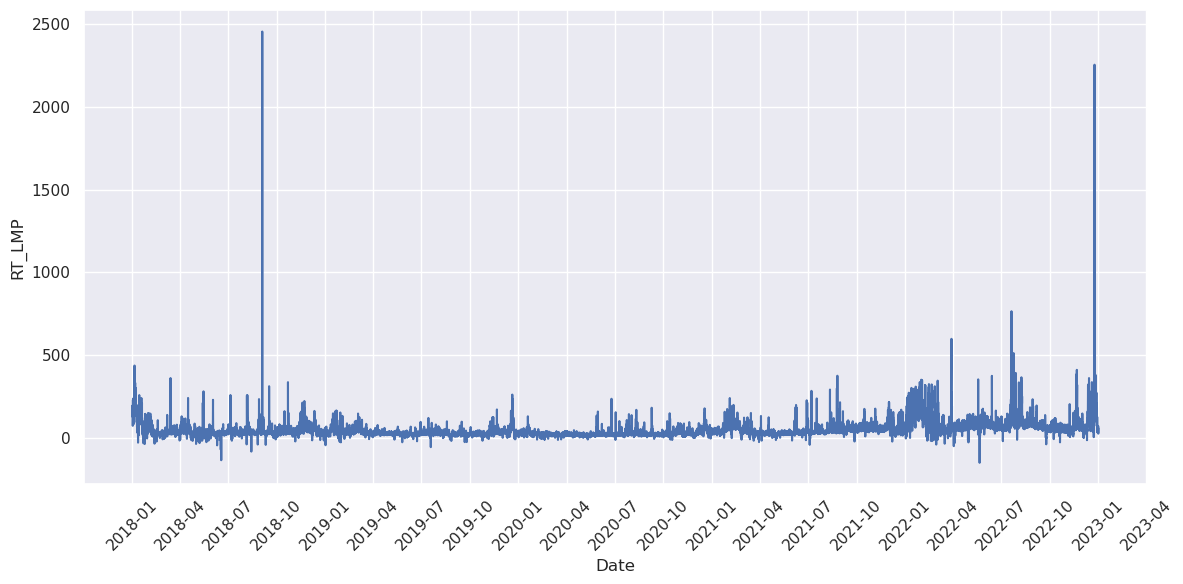

In [7]:
plt.figure(figsize=(12, 6))  

ax = sns.lineplot(x=df.index, y='RT_LMP', data=df)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.xticks(rotation=45)  
plt.tight_layout()  

This one shows some outliers

## Split data for train & test

In [8]:
train_size = int(len(df) * 0.9) 
train, test = df['RT_LMP'].iloc[:train_size].reset_index().set_index('Date'), df['RT_LMP'].iloc[train_size:].reset_index().set_index('Date')

In [9]:
df

,RT_LMP
Date,
2018-01-01 01:00:00,146.39
2018-01-01 02:00:00,134.27
2018-01-01 03:00:00,133.55
2018-01-01 04:00:00,141.81
2018-01-01 05:00:00,136.80
...,...
2022-12-31 20:00:00,26.36
2022-12-31 21:00:00,25.38
2022-12-31 22:00:00,31.80


In [10]:
train

,RT_LMP
Date,
2018-01-01 01:00:00,146.39
2018-01-01 02:00:00,134.27
2018-01-01 03:00:00,133.55
2018-01-01 04:00:00,141.81
2018-01-01 05:00:00,136.80
...,...
2022-07-02 05:00:00,52.37
2022-07-02 06:00:00,50.91
2022-07-02 07:00:00,49.23


# ARIMA Univariate

## Check stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['RT_LMP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.030757
p-value: 0.000000


Again we can assume the time series is stationary

## Autocorrelation Function and the Partial Autocorrelation Function. 

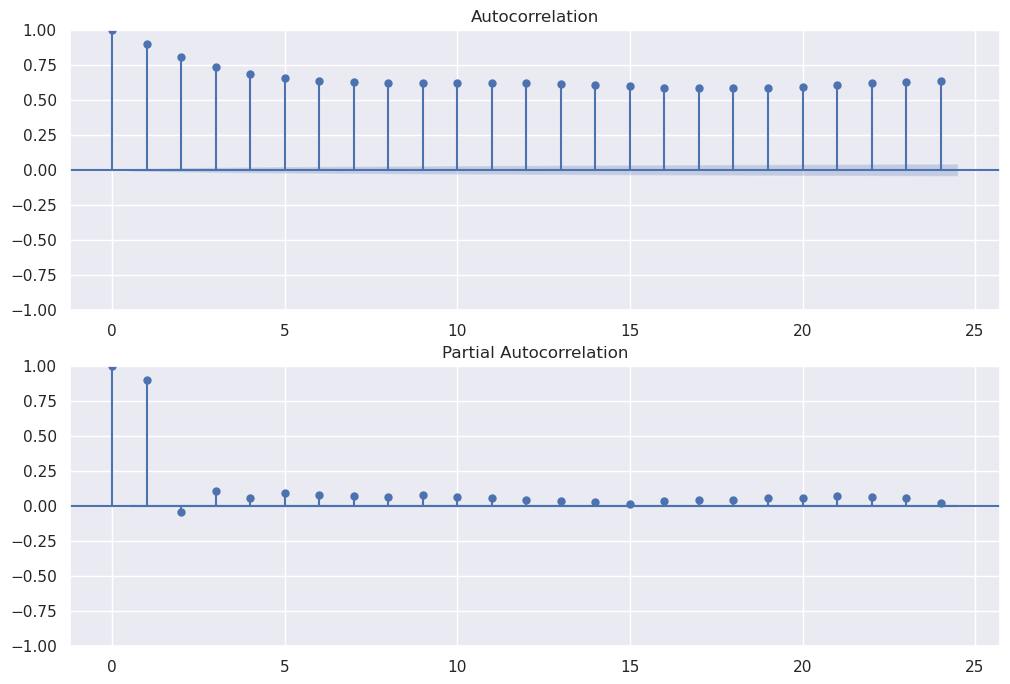

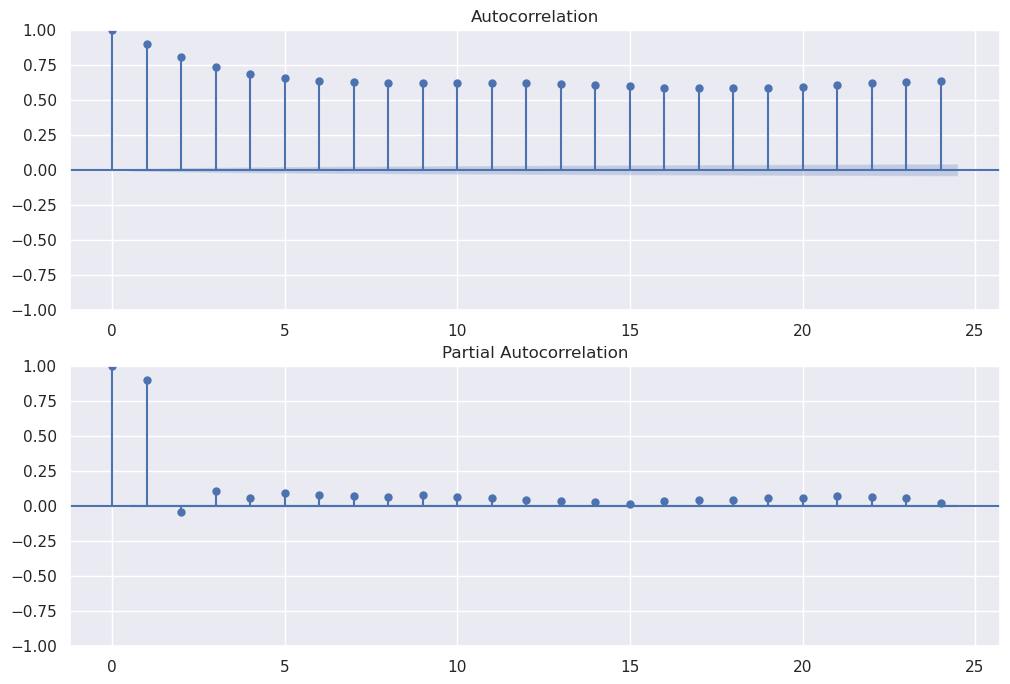

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train['RT_LMP'], lags=24, ax=ax1)
plot_pacf(train['RT_LMP'], lags=24, method='ywm', ax=ax2)

The autocorrelation is high for the first three lags and then levels off. This suggests that there might be some MA components to consider in the model, possibly up to MA(3).
The partial autocorrelation is very high for the first two lags and then is close to zero afterwards. This typically indicates that an AR(2) model might be appropriate, as the significance of the PACF after lag 2 drops off, suggesting that the autoregressive part of the model should include two lags.

## ARIMA

Based on the observations from the ACF and PACF plots, starting with an ARIMA(2, 0, 1) model but also trying different configurations.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                 RT_LMP   No. Observations:                39441
Model:                 ARIMA(2, 0, 0)   Log Likelihood             -167905.120
Date:                Sat, 27 Apr 2024   AIC                         335818.240
Time:                        22:01:32   BIC                         335852.570
Sample:                    01-01-2018   HQIC                        335829.113
                         - 07-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4160      1.144     36.206      0.000      39.174      43.658
ar.L1          0.9404      0.000   4946.247      0.000       0.940       0.941
ar.L2         -0.0440      0.000   -1

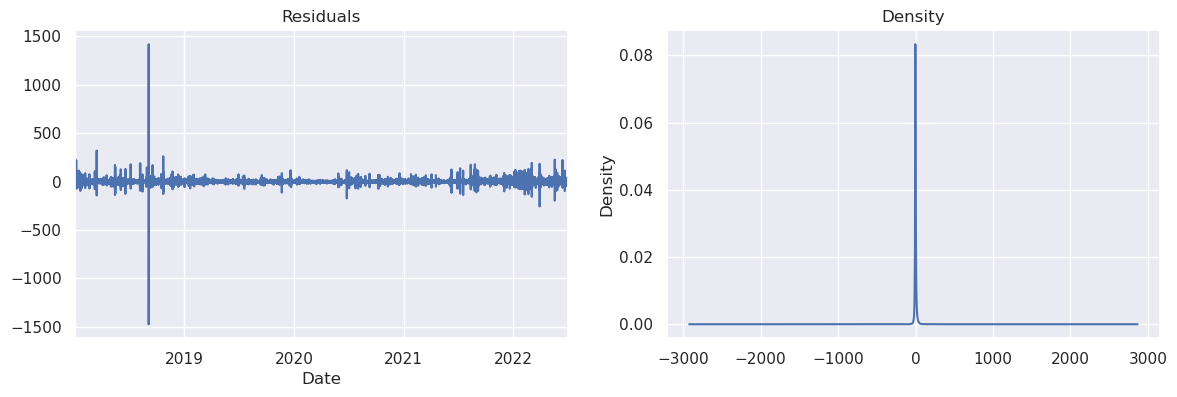

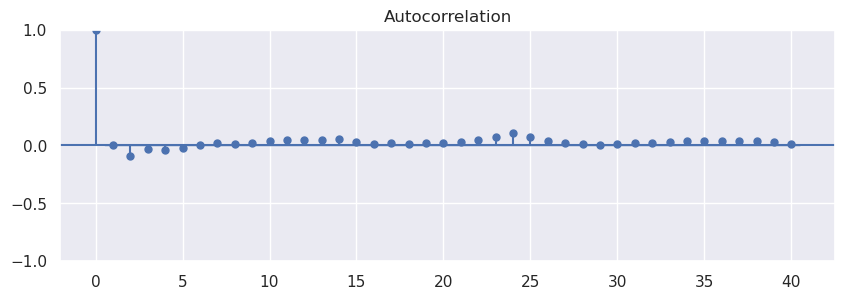

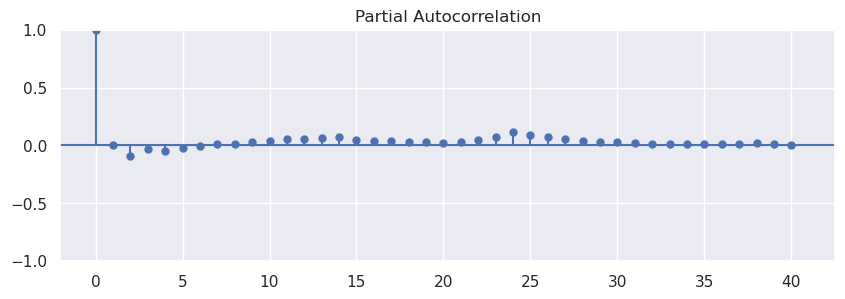

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 3)
                               SARIMAX Results                                
Dep. Variable:                 RT_LMP   No. Observations:                39441
Model:                 ARIMA(0, 0, 3)   Log Likelihood             -173378.026
Date:                Sat, 27 Apr 2024   AIC                         346766.052
Time:                        22:01:40   BIC                         346808.965
Sample:                    01-01-2018   HQIC                        346779.644
                         - 07-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4163      0.376    110.245      0.000      40.680      42.153
ma.L1          1.0309      0.000   3808.318      0.000       1.030       1.031
ma.L2          0.7400      0.000   17

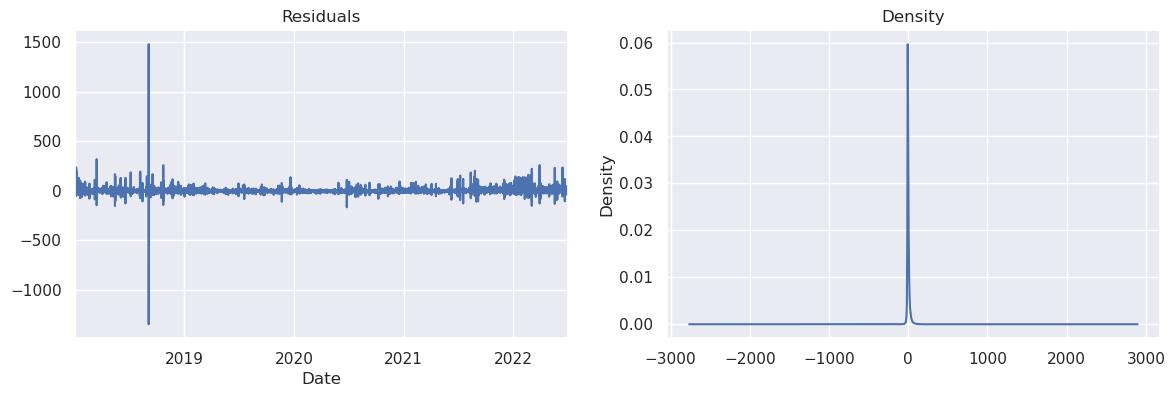

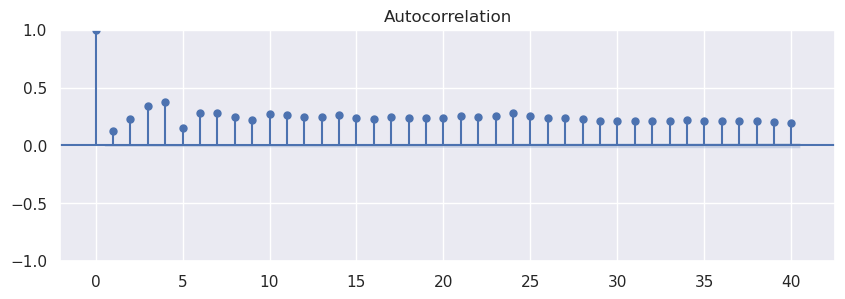

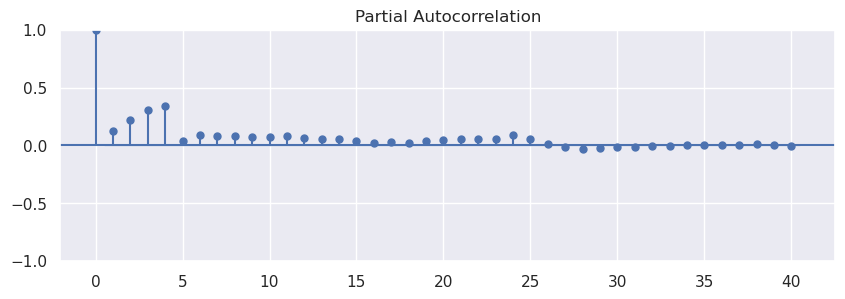

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

ARIMA(2, 0, 3)
                               SARIMAX Results                                
Dep. Variable:                 RT_LMP   No. Observations:                39441
Model:                 ARIMA(2, 0, 3)   Log Likelihood             -166620.142
Date:                Sat, 27 Apr 2024   AIC                         333254.283
Time:                        22:02:08   BIC                         333314.361
Sample:                    01-01-2018   HQIC                        333273.312
                         - 07-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4246      4.867      8.512      0.000      31.886      50.963
ar.L1          1.6316      0.004    389.415      0.000       1.623       1.640
ar.L2         -0.6334      0.004   -1

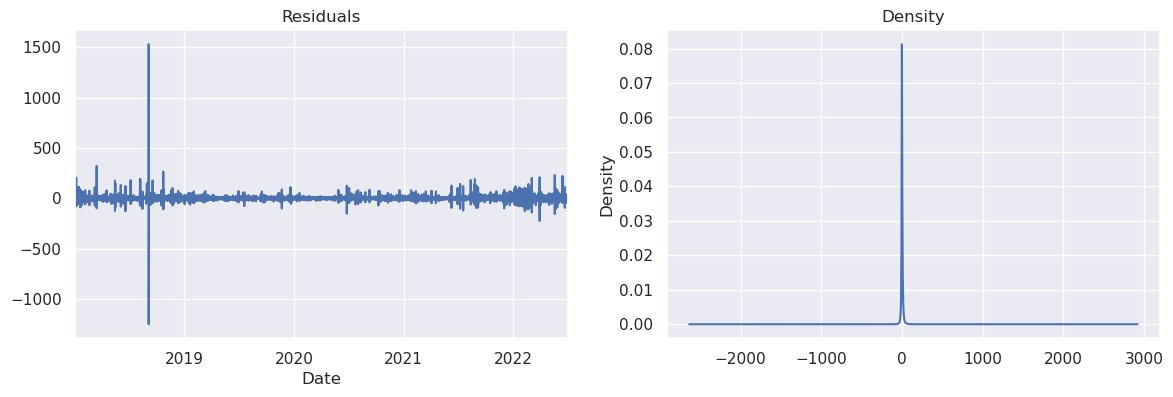

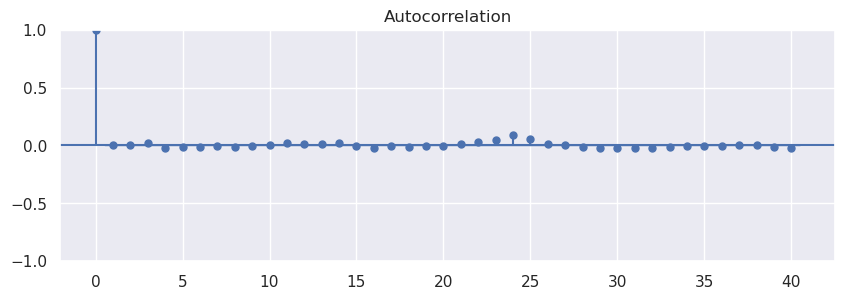

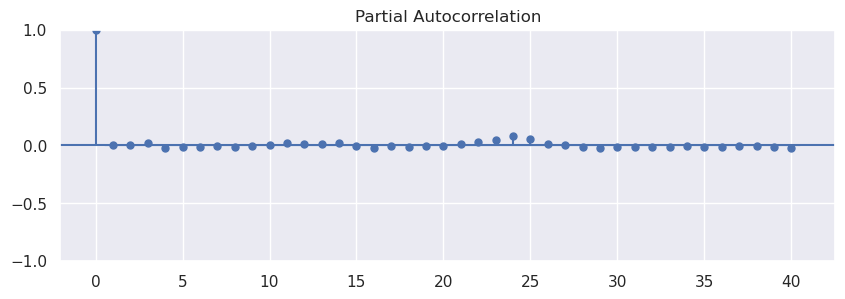

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA(3, 0, 3)
                               SARIMAX Results                                
Dep. Variable:                 RT_LMP   No. Observations:                39441
Model:                 ARIMA(3, 0, 3)   Log Likelihood             -166619.797
Date:                Sat, 27 Apr 2024   AIC                         333255.594
Time:                        22:02:32   BIC                         333324.254
Sample:                    01-01-2018   HQIC                        333277.341
                         - 07-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4181      5.118      8.093      0.000      31.388      51.449
ar.L1          0.6703      0.035     19.157      0.000       0.602       0.739
ar.L2          0.9513      0.057     

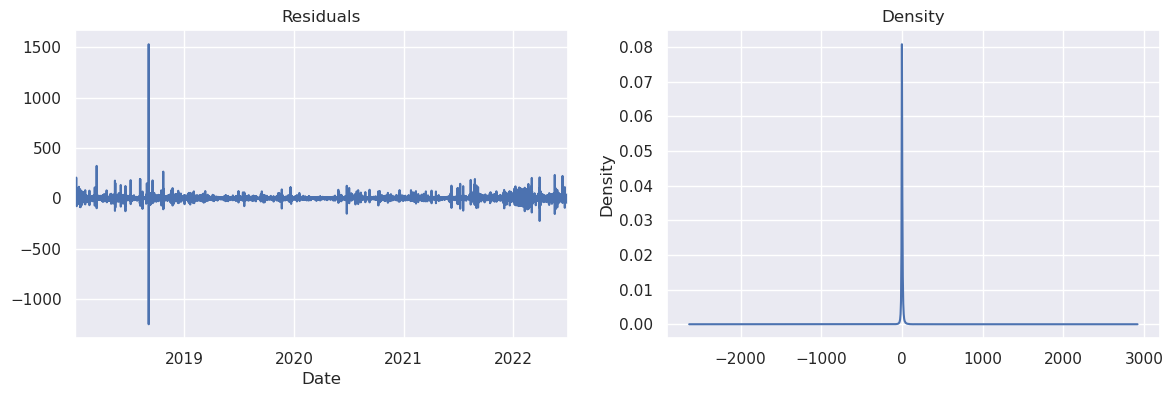

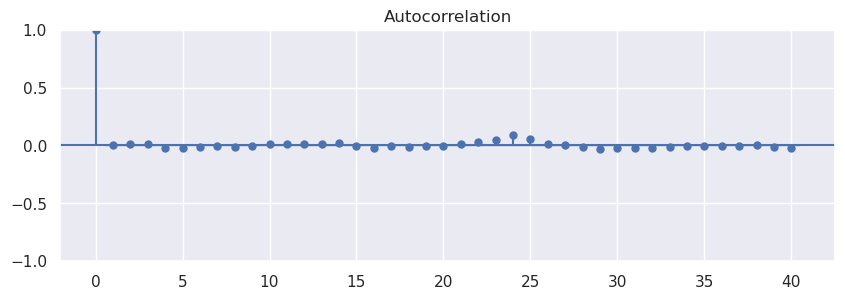

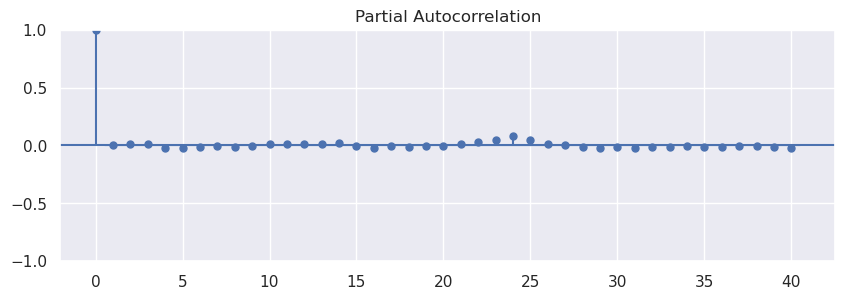

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm

def fit_arima_and_check_residuals(data, order):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    
    print(f"ARIMA{order}")
    print(model_fit.summary())
    
    residuals = model_fit.resid
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    
    # check if residuals are normally distributed
    mean, std = norm.fit(residuals)
    print(f"Residuals are normally distributed with mean {mean} and std {std}: ", 
          "Yes" if std > 0 else "No")
    
    # plot ACF of residuals
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_acf(residuals, ax=ax, lags=40)
    plt.show()
    
    # plot PACF of residuals
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_pacf(residuals, ax=ax, lags=40, method='ywm')
    plt.show()

    return model_fit


orders = [(2, 0, 0), (0, 0, 3), (2, 0, 3), (3, 0, 3)]

for order in orders:
    fit_arima_and_check_residuals(train['RT_LMP'], order)

ARIMA(3, 0, 3) seems to be the best model.

# Predicts and check error

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = ARIMA(train, order=(3, 0, 3))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)  
r_squared = r2_score(test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r_squared}')

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

MAE: 42.7848517458197
MSE: 6698.26395728273
RMSE: 81.8429224629884
R-squared: -0.3098223028222906


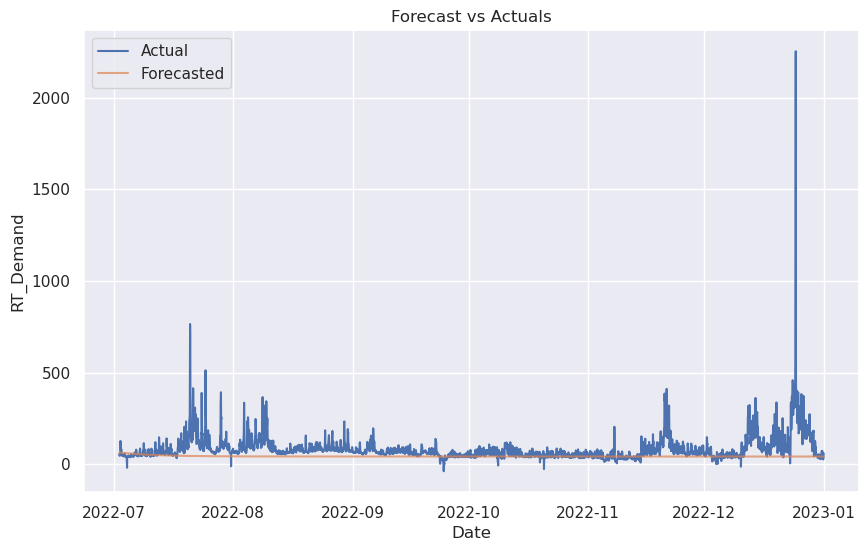

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Forecasted', alpha=0.7)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('RT_Demand')
plt.legend()
plt.show()

MAE for the first 24 hours: 15.817957394691655
MSE for the first 24 hours: 404.2873410067568
RMSE for the first 24 hours: 20.106897846429636
R-squared for the first 24 hours: 0.04377671260985261


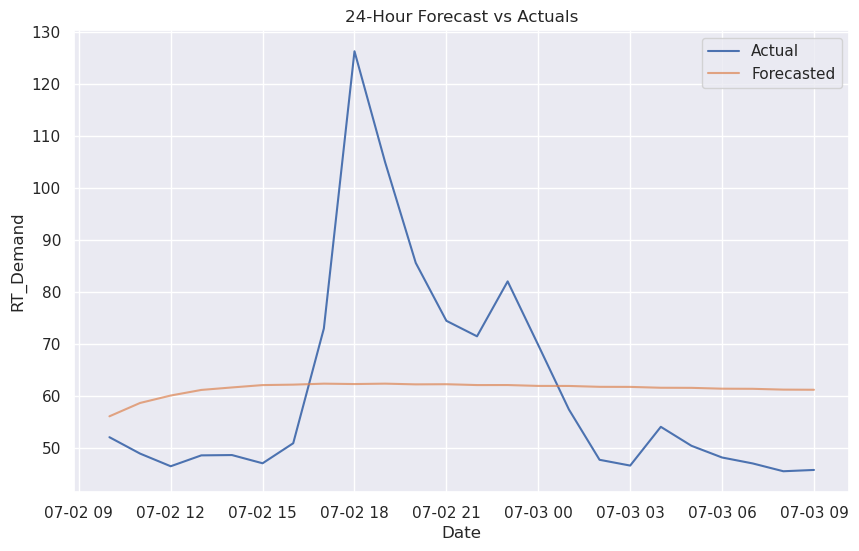

In [16]:
hours_to_predict = 24

next_24_hours = model_fit.forecast(steps=hours_to_predict)

forecast_index = pd.date_range(start=test.index[0], periods=hours_to_predict, freq='H')

forecast_series = pd.Series(next_24_hours, index=forecast_index)

mae = mean_absolute_error(test[:hours_to_predict], forecast_series)
mse = mean_squared_error(test[:hours_to_predict], forecast_series)
rmse = np.sqrt(mse)  
r_squared = r2_score(test[:hours_to_predict], forecast_series)

print(f'MAE for the first {hours_to_predict} hours: {mae}')
print(f'MSE for the first {hours_to_predict} hours: {mse}')
print(f'RMSE for the first {hours_to_predict} hours: {rmse}')
print(f'R-squared for the first {hours_to_predict} hours: {r_squared}')

plt.figure(figsize=(10, 6))
plt.plot(test[:hours_to_predict].index, test[:hours_to_predict], label='Actual')
plt.plot(forecast_series.index, forecast_series, label='Forecasted', alpha=0.7)
plt.title(f'{hours_to_predict}-Hour Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('RT_Demand')
plt.legend()
plt.show()

# Now using RT_Demand as an exogenous variable so later we can benchmark the cascade

In [17]:
df = pd.read_csv('../1_Data/datasets/from2018.csv')

In [18]:
df = df[['Date', 'DA_Demand', 'RT_LMP']].sort_values('Date')
df = df.set_index('Date')

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima(data, order):
    
    model = SARIMAX(train['RT_LMP'], exog=train[['RT_Demand']], order=order)
    model_fit = model.fit()
    
    print(f"SARIMA{order}")
    print(model_fit.summary())
    
    residuals = model_fit.resid
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    
    # check if residuals are normally distributed
    mean, std = norm.fit(residuals)
    print(f"Residuals are normally distributed with mean {mean} and std {std}: ", 
          "Yes" if std > 0 else "No")
    
    # plot ACF of residuals
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_acf(residuals, ax=ax, lags=40)
    plt.show()
    
    # plot PACF of residuals
    fig, ax = plt.subplots(figsize=(10, 3))
    plot_pacf(residuals, ax=ax, lags=40, method='ywm')
    plt.show()

    return model_fit


orders = [(2, 0, 0), (0, 0, 3), (1, 0, 1), (3, 0, 3)]
# orders = [(1, 0, 1)]


for order in orders:
    fit_sarima(train, order)

KeyError: "None of [Index(['RT_Demand'], dtype='object')] are in the [columns]"

SARIMA (1, 0, 1) best model

In [ ]:
n_forecast = 24  # number of steps to forecast
n_splits = 5     # number of cross-validation splits

metrics = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

for i in range(n_splits):
    train_size = int(len(df) * (0.9 - (i * 0.01)))  
    train, test = df.iloc[:train_size], df.iloc[train_size:train_size + n_forecast]

    model_lmp = SARIMAX(train['RT_LMP'], exog=train[['RT_Demand']], order=(1, 0, 1))
    model_lmp_fit = model_lmp.fit(method='bfgs')
    forecast_lmp = model_lmp_fit.get_forecast(steps=n_forecast, exog=test[['RT_Demand']])

    actual_lmp = test['RT_LMP'].values
    predicted_lmp = forecast_lmp.predicted_mean

    metrics['MAE'].append(mean_absolute_error(actual_lmp, predicted_lmp))
    metrics['MSE'].append(mean_squared_error(actual_lmp, predicted_lmp))
    metrics['RMSE'].append(rmse(actual_lmp, predicted_lmp))
    metrics['R2'].append(r2_score(actual_lmp, predicted_lmp))

avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}

print("Average metrics for RT_LMP using actual RT_Demand as exogenous:")
print(avg_metrics)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

n_forecast = 24  
n_splits = 5     

metrics = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

last_actual_lmp = None
last_predicted_lmp = None

for i in range(n_splits):
    train_size = int(len(df) * (0.9 - (i * 0.01)))  # Gradually reduce training size
    train, test = df.iloc[:train_size], df.iloc[train_size:train_size + n_forecast]

    model_lmp = SARIMAX(train['RT_LMP'], exog=train[['RT_Demand']], order=(1, 0, 1))
    model_lmp_fit = model_lmp.fit()
    forecast_lmp = model_lmp_fit.get_forecast(steps=n_forecast, exog=test[['RT_Demand']])

    actual_lmp = test['RT_LMP'].values
    predicted_lmp = forecast_lmp.predicted_mean

    if i == n_splits - 1:
        last_actual_lmp = actual_lmp
        last_predicted_lmp = predicted_lmp

    metrics['MAE'].append(mean_absolute_error(actual_lmp, predicted_lmp))
    metrics['MSE'].append(mean_squared_error(actual_lmp, predicted_lmp))
    metrics['RMSE'].append(rmse(actual_lmp, predicted_lmp))
    metrics['R2'].append(r2_score(actual_lmp, predicted_lmp))

avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}

print("Average metrics for RT_LMP using actual RT_Demand as exogenous:")
print(avg_metrics)

plt.figure(figsize=(10, 5))
plt.plot(range(n_forecast), last_actual_lmp, label='Actual RT_LMP', marker='o')
plt.plot(range(n_forecast), last_predicted_lmp, label='Predicted RT_LMP', marker='x')
plt.title('Actual vs Predicted RT_LMP for the Last Fold')
plt.xlabel('Time Steps')
plt.ylabel('RT_LMP')
plt.legend()
plt.show()
